In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from tqdm import tqdm
import argparse

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.utils import save_image


from autoencoder import Autoencoder
from solver import *
from receptive_field import get_RF_linear

%load_ext autoreload
%autoreload 2

### Load model

In [2]:
modelpath = '/home/david/sparsify_models/good_models/01/'
plotpath = '/home/david/sparsify_plots/RF/'
if not os.path.exists(plotpath):
    os.makedirs(plotpath)

In [3]:
def load_model(model_path, model_type, epoch):
    n_input = 28*28
    n_layers = 3
    sae_n_hidden_ls = [512, 128, 32]

    size_ls = [4, 4, 4, 4, 4, 10,
            10, 10, 10, 10, 16, 16,
            16, 16, 16, 16, 16, 24,
            24, 24, 24, 24, 24, 24, 
            32, 32, 32, 32, 32, 32,
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32, 32, 32, 32, 32, 
            32, 32]
    
    dae_n_hidden_ls = [512, 128, size_ls[epoch]]
    
    if model_type == 'SAE':
        model = Autoencoder(n_input, sae_n_hidden_ls, n_layers)
    else:
        model = Autoencoder(n_input, dae_n_hidden_ls, n_layers)
    weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")
    model.load_state_dict(weights)
    return model

In [4]:
sae = load_model(modelpath, 'SAE', 49)
dae = load_model(modelpath, 'DAE', 49)

/tmp/ipykernel_54252/2098548407.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/{model_type}/model_weights_epoch{epoch}.pth")


### Load data

In [5]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 128
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=6)

In [6]:
from torch.utils.data import DataLoader, TensorDataset

test_images = []
test_labels = []

for batch_idx, (data, target) in enumerate(test_loader):
    data = Variable(data).to('cuda')
    input = data.view(data.size(0), -1).to('cuda')
    test_images.append(input.cpu().numpy())
    test_labels.append(target.cpu().numpy())

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)


sae_encodings = []

with torch.no_grad():
    for image in test_images:
        image = torch.tensor(image).to('cpu')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae(input)
        sae_encodings.append(encoded.cpu().detach())

sae_encodings_tensor = torch.cat(sae_encodings)


dae_encodings = []

with torch.no_grad():
    for image in test_images:
        image = torch.tensor(image).to('cpu')
        input = image.view(1, -1).to('cpu')
        encoded, decoded = sae(input)
        dae_encodings.append(encoded.cpu().detach())

dae_encodings_tensor = torch.cat(dae_encodings)

# Create a new DataLoader with the encodings
sae_encoding_dataset = TensorDataset(sae_encodings_tensor, torch.tensor(test_labels))
sae_encoding_loader = DataLoader(sae_encoding_dataset, batch_size=64, shuffle=False)

dae_encoding_dataset = TensorDataset(dae_encodings_tensor, torch.tensor(test_labels))
dae_encoding_loader = DataLoader(dae_encoding_dataset, batch_size=64, shuffle=False)

### Activation Maximization

In [50]:
import act_max_util as amu
activation_dictionary = {}
layer_name = 'bottle_neck'

sae.encoder.encoder_3.register_forward_hook(amu.layer_hook(activation_dictionary, layer_name))

In [48]:
data = torch.randn(28, 28)
data = data.unsqueeze(0)
input = data.view(data.size(0), -1)
input.requires_grad_(True)

print(input.shape)

torch.Size([1, 784])


In [9]:
steps = 100               # perform 100 iterations
unit = 0                  # flamingo class of Imagenet
alpha = torch.tensor(100) # learning rate (step size)
verbose = False           # print activation every step
L2_Decay = True           # enable L2 decay regularizer
Gaussian_Blur = False     # enable Gaussian regularizer
Norm_Crop = False         # enable norm regularizer
Contrib_Crop = False      # enable contribution regularizer

In [51]:
sae_rf_ls = []
for i in range(32):
    output = amu.act_max(network=sae,
                    input=input,
                    layer_activation=activation_dictionary,
                    layer_name=layer_name,
                    unit=i,
                    steps=steps,
                    alpha=alpha,
                    verbose=verbose,
                    L2_Decay=L2_Decay,
                    Gaussian_Blur=Gaussian_Blur,
                    Norm_Crop=Norm_Crop,
                    Contrib_Crop=Contrib_Crop,
                    )
    sae_rf_ls.append(output.detach().numpy())

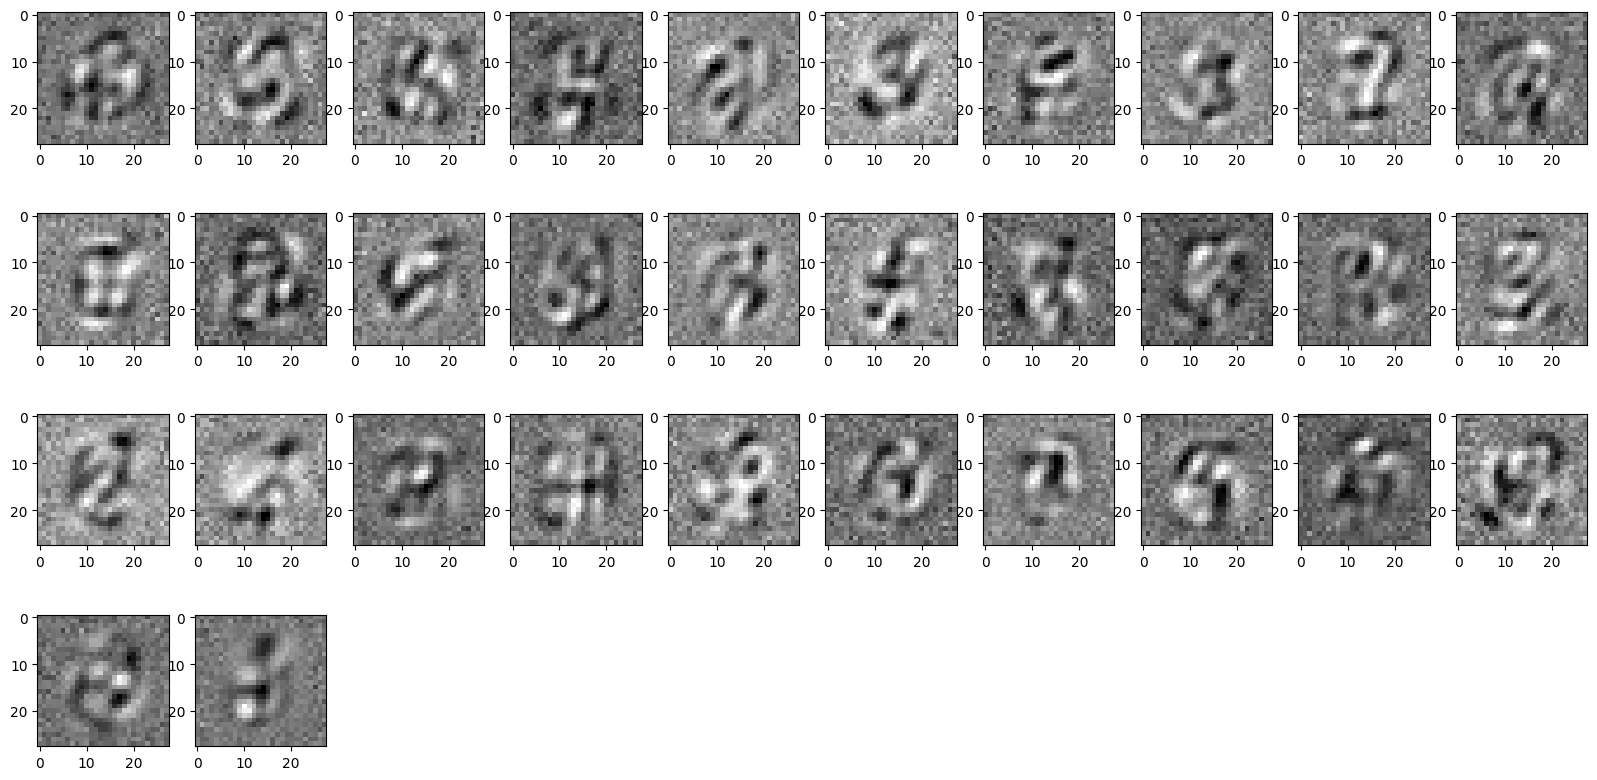

In [ ]:
fig = plt.figure(figsize=(20,10))
for i in range(32):
    plt.subplot(4,10,i+1)
    plt.imshow(sae_rf_ls[i].reshape(28,28),cmap='binary_r')
plt.savefig(plotpath + 'sae_maxact.pdf',bbox_inches='tight')

In [14]:
activation_dictionary = {}
layer_name = 'bottle_neck'

dae.encoder.encoder_3.register_forward_hook(amu.layer_hook(activation_dictionary, layer_name))

In [15]:
dae_rf_ls = []
for i in range(32):
    output = amu.act_max(network=dae,
                    input=input,
                    layer_activation=activation_dictionary,
                    layer_name=layer_name,
                    unit=i,
                    steps=steps,
                    alpha=alpha,
                    verbose=verbose,
                    L2_Decay=L2_Decay,
                    Gaussian_Blur=Gaussian_Blur,
                    Norm_Crop=Norm_Crop,
                    Contrib_Crop=Contrib_Crop,
                    )
    dae_rf_ls.append(output.detach().numpy())

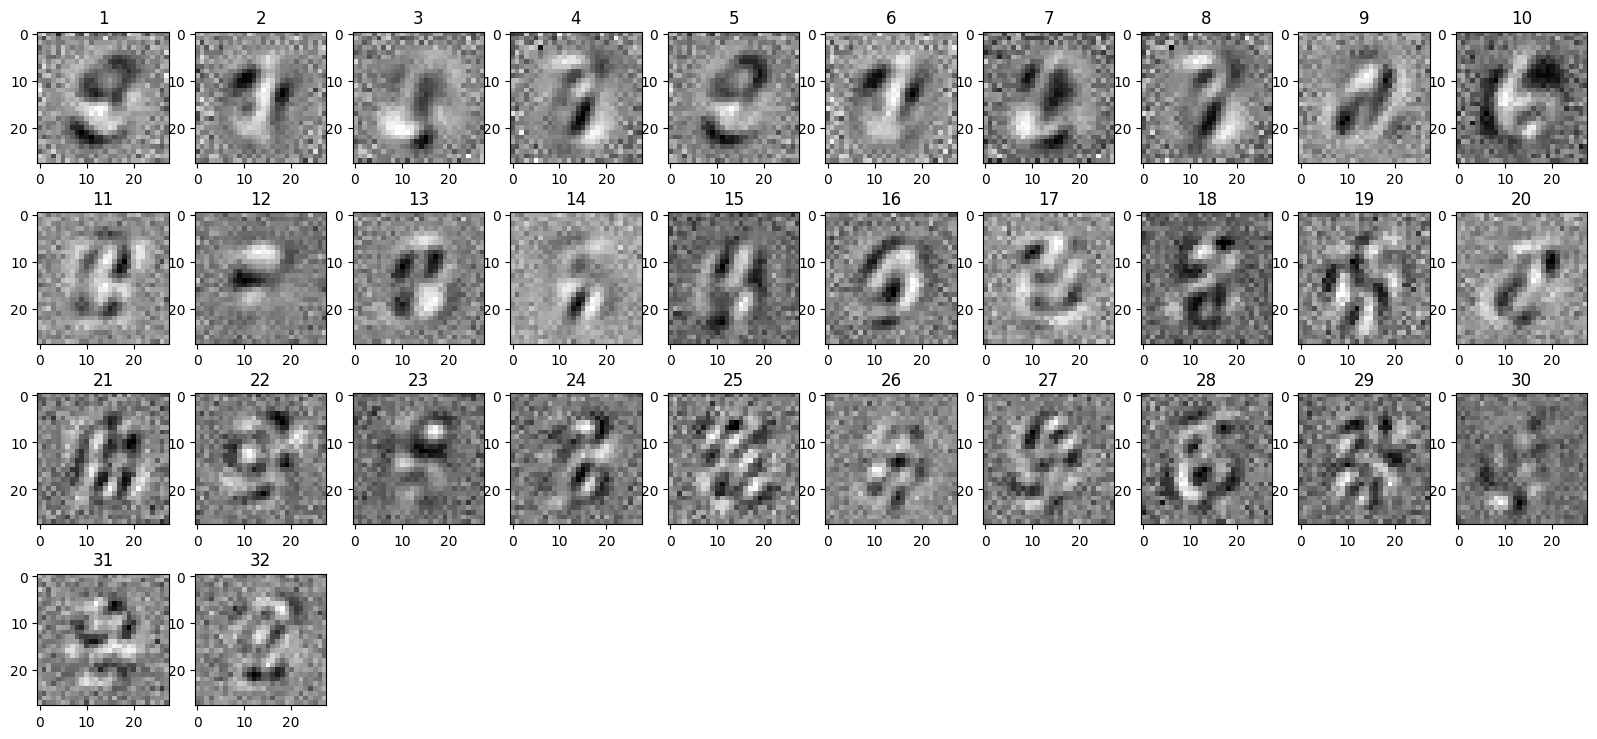

In [16]:
fig = plt.figure(figsize=(20,9))
for i in range(32):
    plt.subplot(4,10,i+1)
    plt.title(str(i+1))
    plt.imshow(dae_rf_ls[i].reshape(28,28),cmap='binary_r')
plt.savefig(plotpath + 'dae_maxact.pdf',bbox_inches='tight')

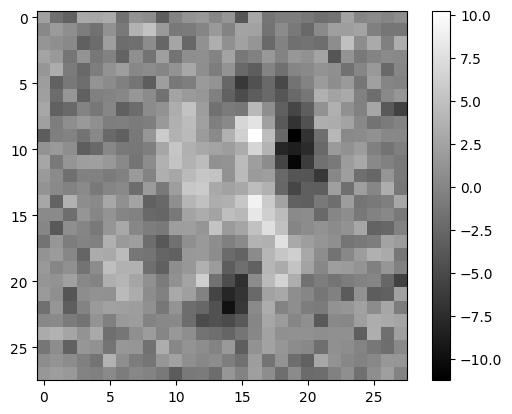

In [17]:
diff = dae_rf_ls[4] - dae_rf_ls[0]
plt.imshow(diff.reshape(28,28),cmap='binary_r')
plt.colorbar()

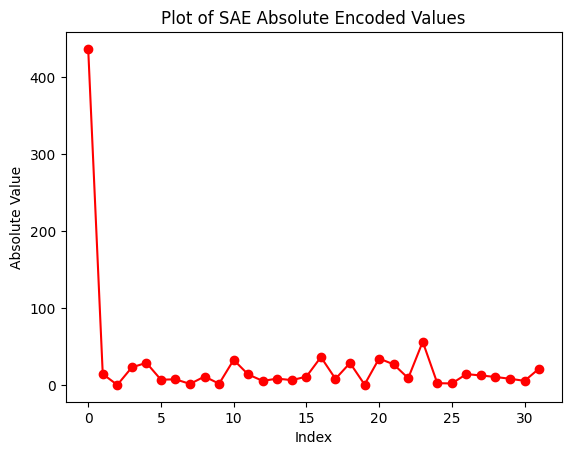

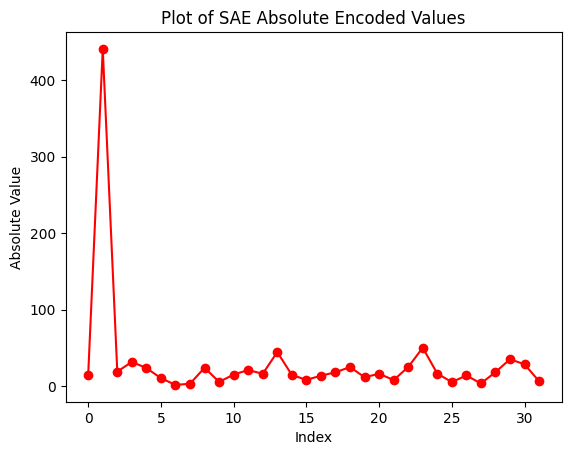

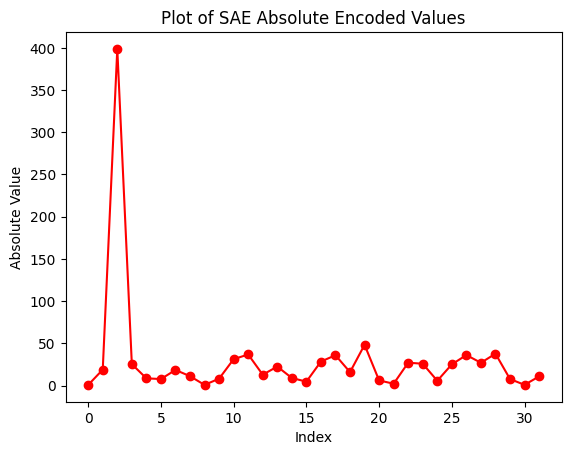

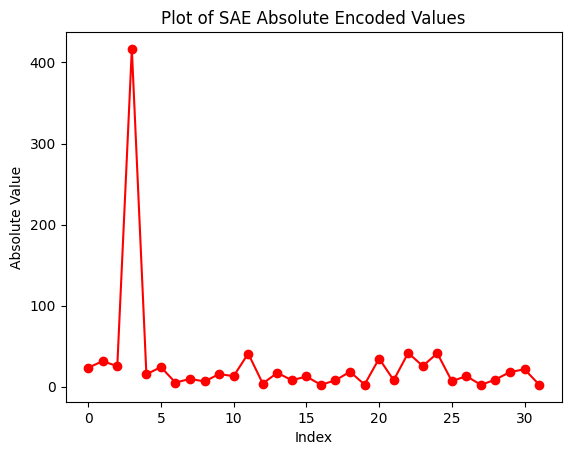

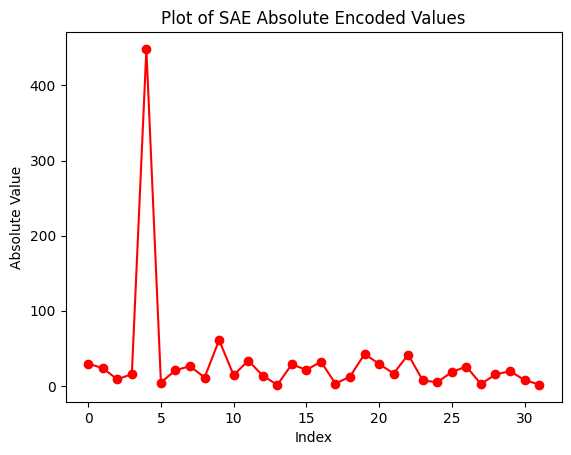

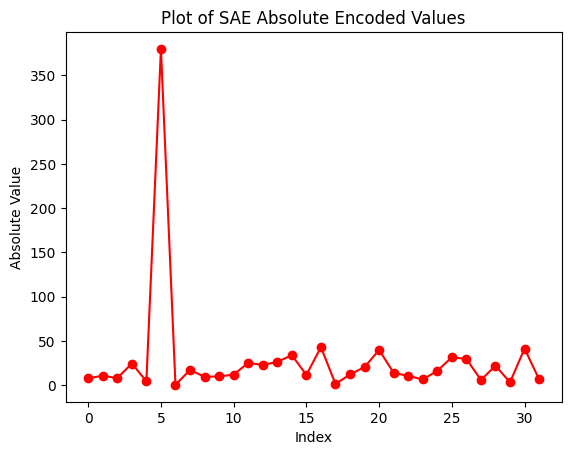

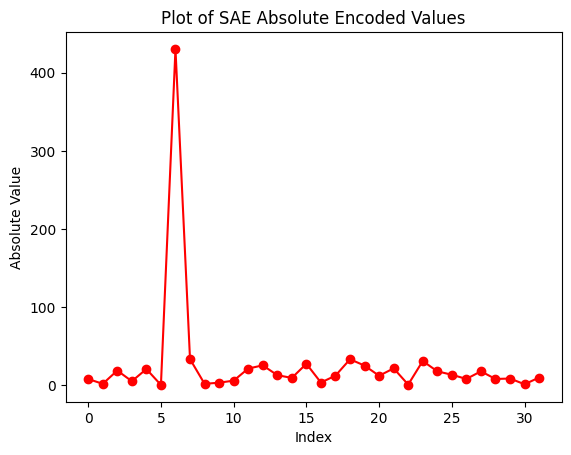

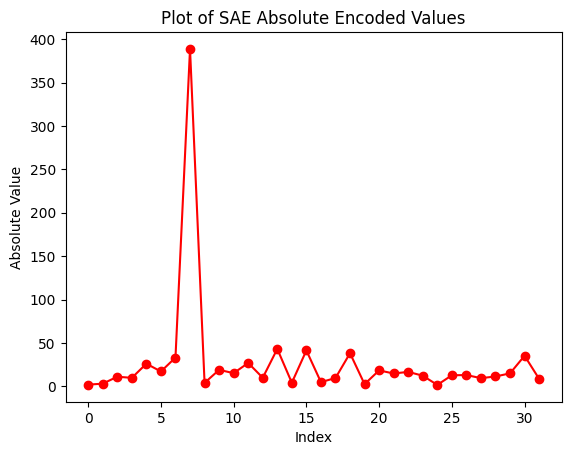

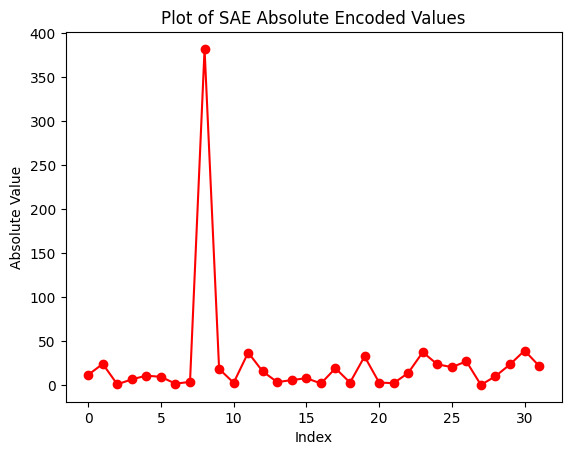

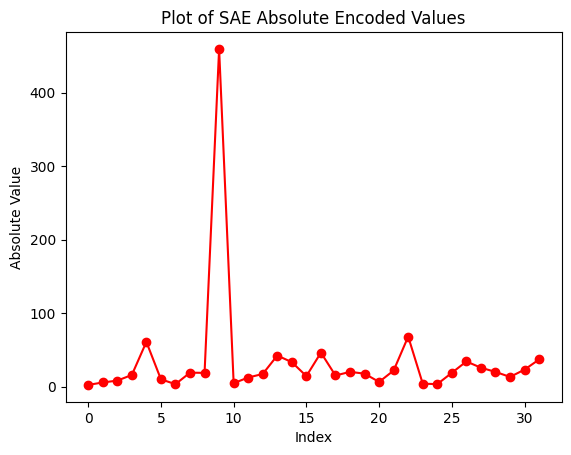

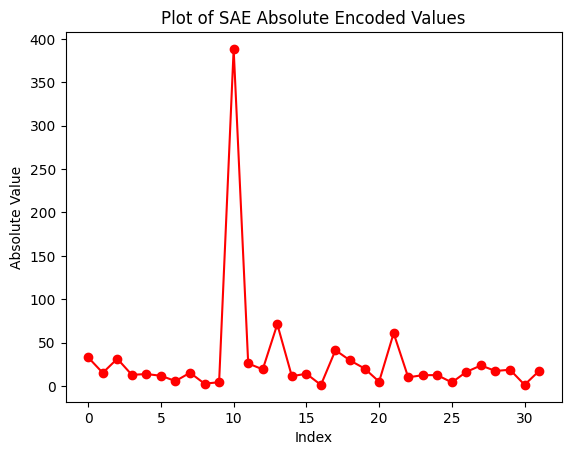

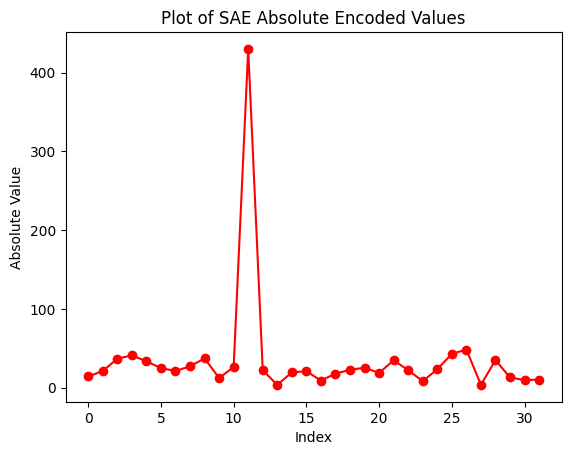

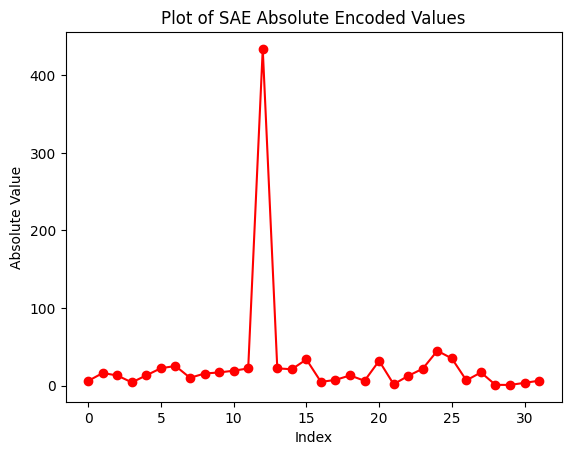

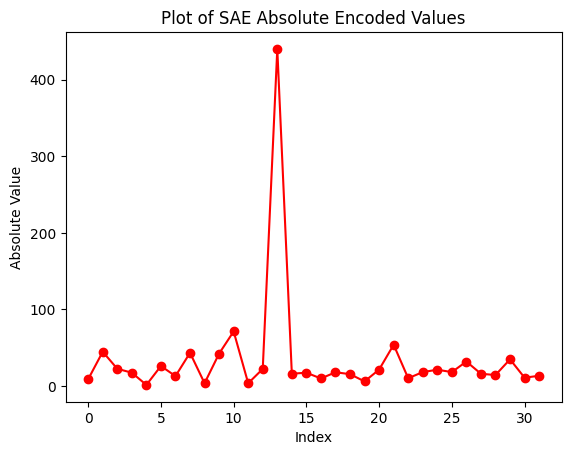

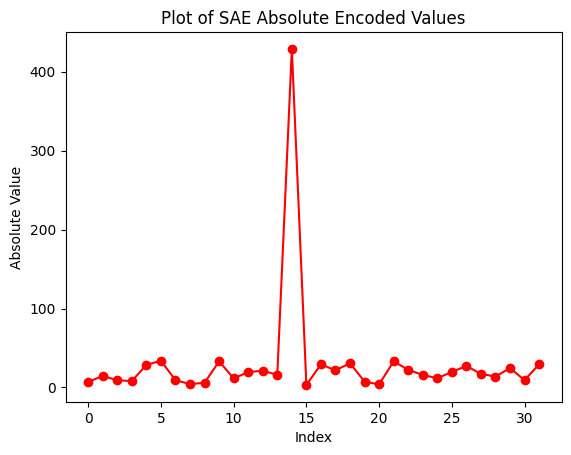

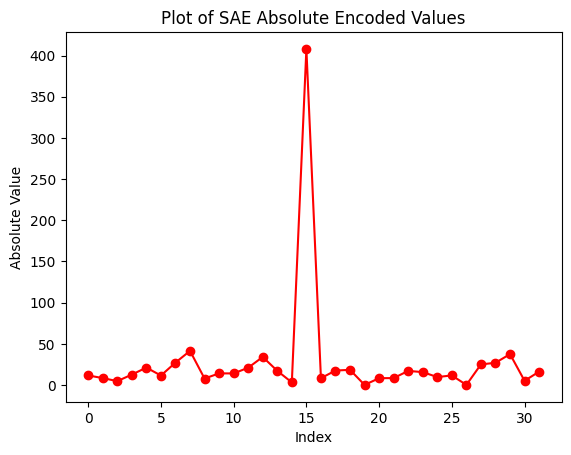

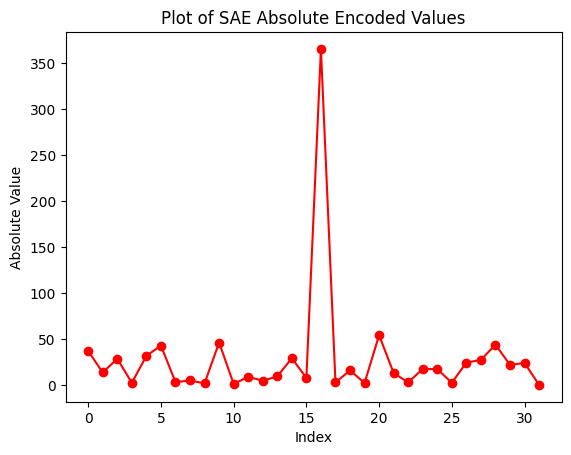

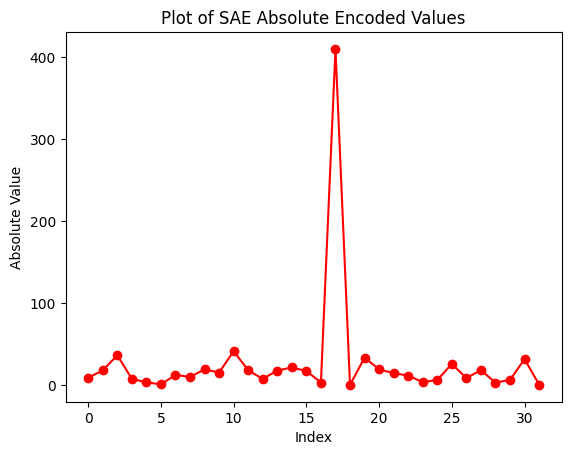

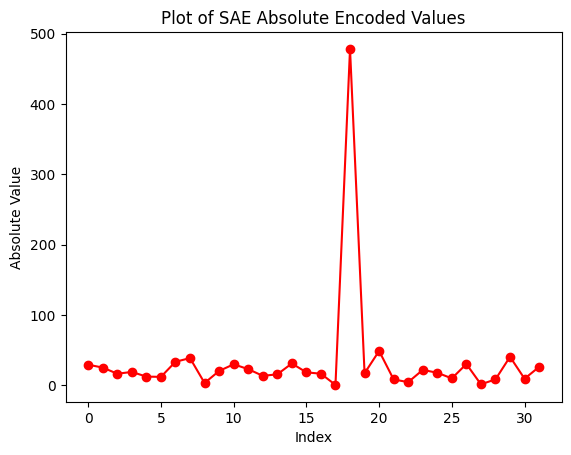

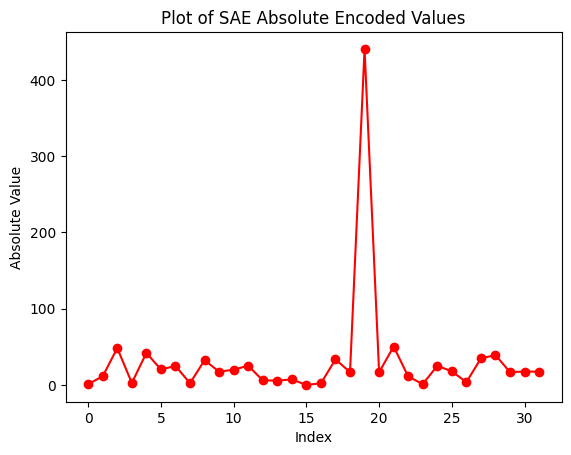

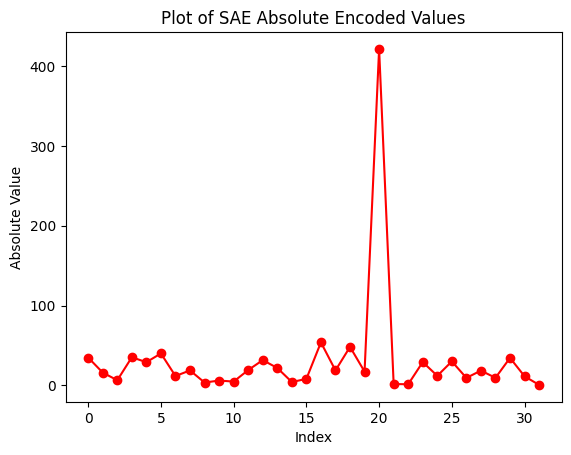

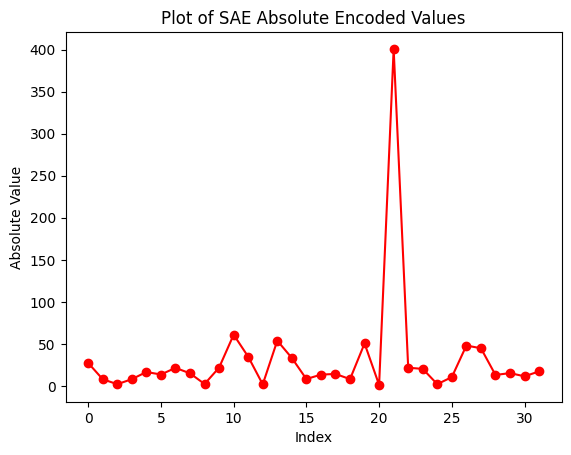

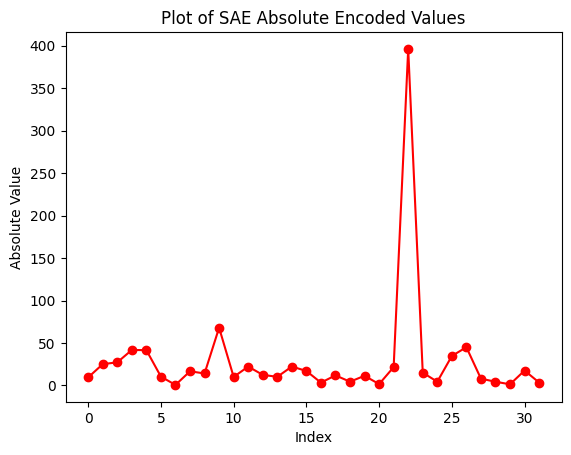

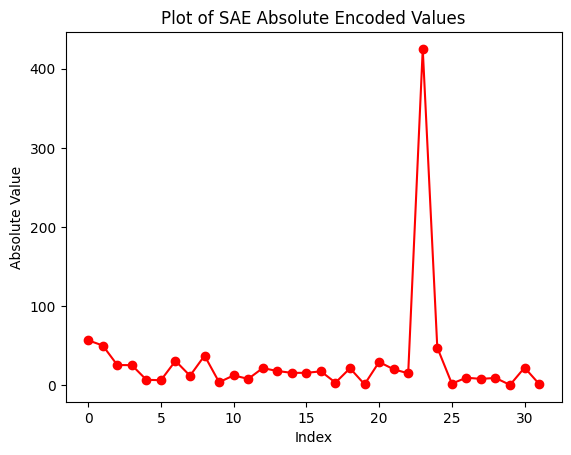

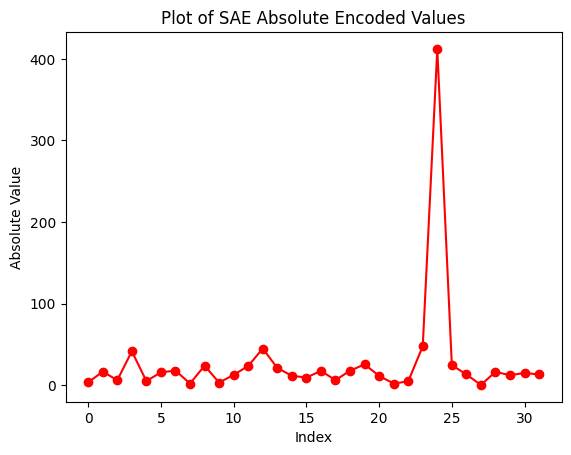

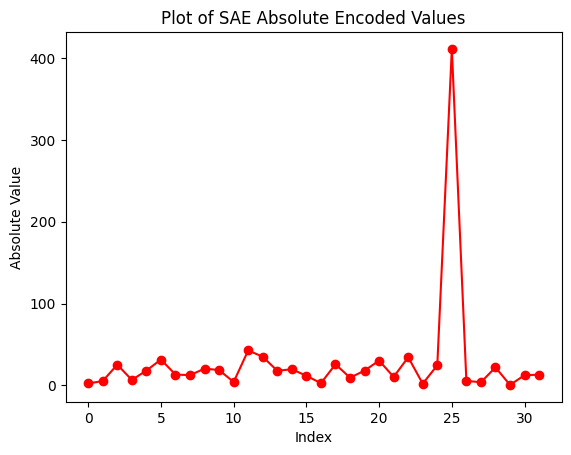

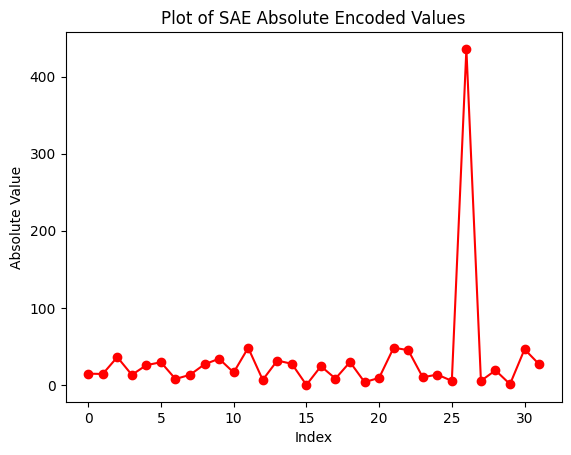

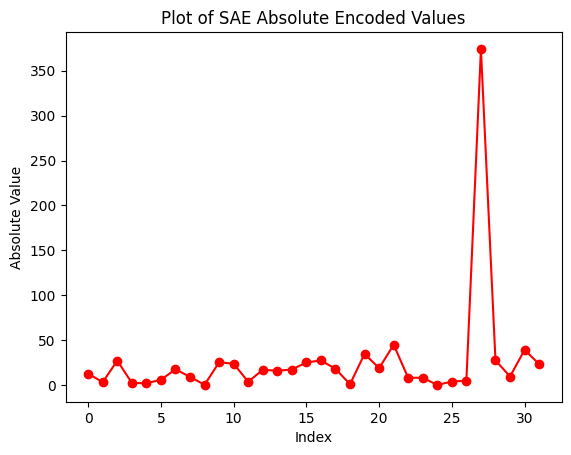

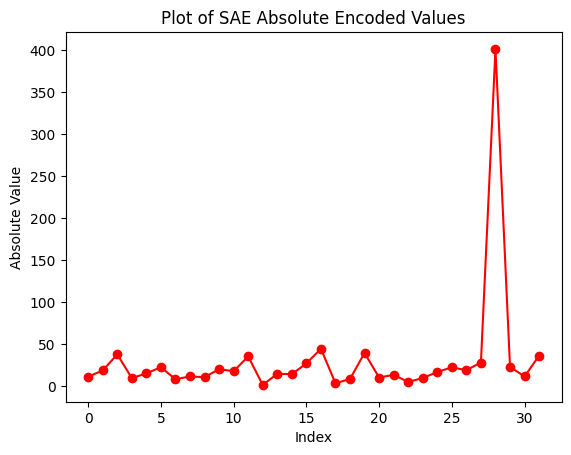

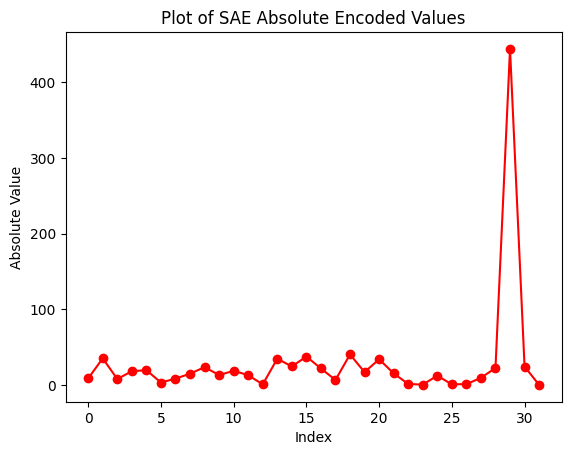

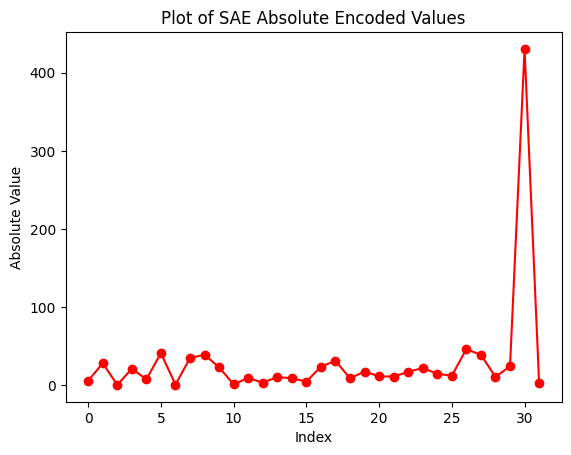

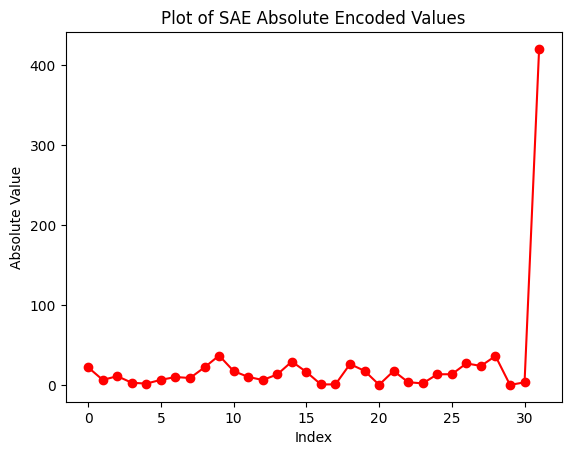

In [26]:
import matplotlib.pyplot as plt
import torch

with torch.no_grad():
    for rf in sae_rf_ls:
        input = torch.tensor(rf).to('cpu')
        encoded, decoded = sae(input)
        sae_absolute_encoded = torch.abs(encoded)
        encoded, decoded = dae(input)
        dae_absolute_encoded = torch.abs(encoded)
        
        # Plotting the values
        plt.figure()
        plt.plot(range(len(sae_absolute_encoded)), sae_absolute_encoded.cpu().numpy(), marker='o', color='red')
        plt.xlabel('Index')
        plt.ylabel('Absolute Value')
        plt.title('Plot of SAE Absolute Encoded Values')
        plt.show()

In [19]:
sae_rf_ls = np.array(sae_rf_ls)
sae_rf_ls = sae_rf_ls[:, 0]

dae_rf_ls = np.array(dae_rf_ls)
dae_rf_ls = dae_rf_ls[:, 0]

In [20]:
sae_rf_ls.shape

(32, 784)

In [25]:
sae_encoded_list = []
dae_encoded_list = []

with torch.no_grad():
    for rf in sae_rf_ls:
        input = torch.tensor(rf).to('cpu')
        encoded, decoded = sae(input)
        sae_absolute_encoded = torch.abs(encoded)
        sae_encoded_list.append(sae_absolute_encoded.cpu().numpy())

with torch.no_grad():
    for rf in dae_rf_ls:
        input = torch.tensor(rf).to('cpu')
        encoded, decoded = dae(input)
        dae_absolute_encoded = torch.abs(encoded)
        dae_encoded_list.append(dae_absolute_encoded.cpu().numpy())

Shape of dae_rf_ls: (32, 32)


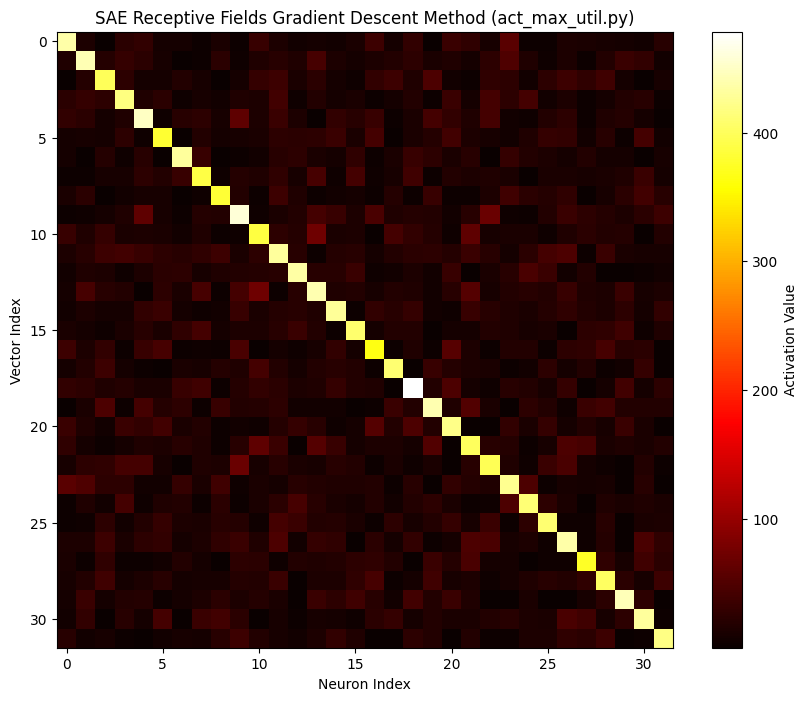

In [22]:
sae_encoded_list = np.array(sae_encoded_list)

plt.figure(figsize=(10, 8))
plt.imshow(sae_encoded_list, cmap='hot', interpolation='nearest')
plt.colorbar(label='Activation Value')
plt.xlabel('Neuron Index')
plt.ylabel('Vector Index')
plt.title('SAE Receptive Fields Gradient Descent Method (act_max_util.py)')
plt.show()

Shape of dae_rf_ls: (32, 32)


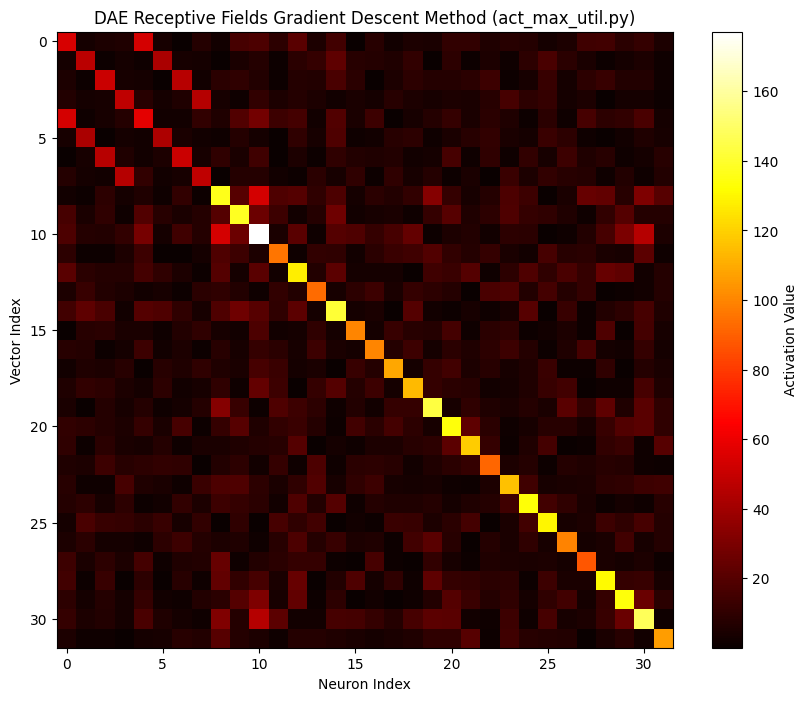

In [ ]:
dae_encoded_list = np.array(dae_encoded_list)

plt.figure(figsize=(10, 8))
plt.imshow(dae_encoded_list, cmap='hot', interpolation='nearest')
plt.colorbar(label='Activation Value')
plt.xlabel('Neuron Index')
plt.ylabel('Vector Index')
plt.title('DAE Receptive Fields Gradient Descent Method (act_max_util.py)')
plt.show()